Tom Genlis - EPITA 2024 - SCIA - CV
# Recommender System based on Neural Networks

In [1]:
# Import necessary libraries for the task
import pandas as pd
from tensorflow.keras import layers, losses, optimizers
import tensorflow_addons as tfa
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import itertools

In [2]:
# Read the data from CSV files into pandas dataframes
df_test_customers = pd.read_csv('../data/test_customers.csv')
df_test_locations = pd.read_csv('../data/test_locations.csv')
df_train_customers = pd.read_csv('../data/train_customers.csv')
df_train_locations = pd.read_csv('../data/train_locations.csv')
df_vendors = pd.read_csv('../data/vendors.csv')
df_orders = pd.read_csv('../data/orders.csv')

C:\Users\Tom\AppData\Local\Temp\ipykernel_4784\2577800560.py:6: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv('../data/orders.csv')


In [12]:
# Functions to clean and format the data

def format_customers(df_customers, df_locations):
    """
    Function to format the customers data
    """
    # Drop unnecessary columns
    df_customers = df_customers.drop(["language", "dob", "created_at", "updated_at"], axis=1)

    # Clean and map gender data
    df_customers["gender"] = df_customers["gender"].str.strip()
    df_customers["gender"] = df_customers["gender"].str.upper()
    df_customers["gender"] = df_customers["gender"].map({'MALE': 0, 'FEMALE': 1})
    df_customers["gender"] = df_customers.gender.fillna(2).astype(int)

    # Select only verified and active customers
    df_customers = df_customers[(df_customers.verified == 1) & (df_customers.status == 1)].drop(["verified", "status"], axis=1)
    df_customers = df_customers.rename(columns={"akeed_customer_id": "customer_id"})

    # Merge with location data
    df_customers = pd.merge(df_customers, df_locations[["customer_id", "location_number", "latitude", "longitude"]], on="customer_id", how="outer")
    df_customers = df_customers.fillna(0)

    # Convert data types to save memory
    df_customers["gender"] = df_customers["gender"].astype(np.uint8)
    df_customers["location_number"] = df_customers["location_number"].astype(np.uint8)
    df_customers["latitude"] = df_customers["latitude"].astype(np.float16)
    df_customers["longitude"] = df_customers["longitude"].astype(np.float16)

    return df_customers

def format_items(df_orders):
    """
    Function to format the items data
    """
    # Drop unnecessary columns
    df_orders = df_orders[["customer_id", "vendor_id", "deliverydistance"]]

    return df_orders

def format_vendors(df_vendors):
    """
    Function to format the vendors data
    """

    # Drop unnecessary columns
    to_remove = [
            "vendor_category_en",
            "authentication_id",
            "OpeningTime",
            "OpeningTime2",
            "open_close_flags",
            "vendor_tag_name",
            "created_at",
            "updated_at",
            "commission",
            "saturday_to_time1",
            "saturday_from_time2",
            "saturday_from_time1",
            "saturday_to_time2",
            "thursday_to_time1",
            "thursday_from_time1",
            "thursday_from_time2",
            "thursday_to_time2",
            "tuesday_to_time1",
            "tuesday_from_time2",
            "tuesday_from_time1",
            "tuesday_to_time2",
            "monday_to_time1",
            "monday_from_time1",
            "monday_from_time2",
            "monday_to_time2",
            "sunday_to_time1",
            "sunday_from_time1",
            "sunday_from_time2",
            "sunday_to_time2",
            "friday_to_time1",
            "friday_from_time1",
            "friday_from_time2",
            "friday_to_time2",
            "wednesday_to_time1",
            "wednesday_from_time1",
            "wednesday_from_time2",
            "wednesday_to_time2",
            "one_click_vendor",
            "country_id",
            "city_id",
            "display_orders",
            "device_type",
            "is_akeed_delivering",
            "language",
            "rank",
            "is_open",
            "verified"
    ]
    df_vendors = df_vendors.drop(to_remove, axis=1)

    # Parse primary_tags
    df_vendors["primary_tags"] = df_vendors["primary_tags"].fillna("{\"primary_tags\":\"0\"}").astype(str).map(lambda x: x.split("\"")[3]).astype(int)

    # One hot encoding for vendor_tag
    df_vendors_tags = df_vendors.vendor_tag.str.split(",")
    df_vendors_tags = df_vendors_tags.apply(lambda d: d if isinstance(d, list) else [])

    mlb = MultiLabelBinarizer()
    one_hot_encoded_data = mlb.fit_transform(df_vendors_tags)
    one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data, columns=mlb.classes_, dtype=bool)

    # Concat df_train_items and one_hot_encoded_data
    df_vendors = df_vendors.drop(["vendor_tag"], axis=1)
    df_vendors = df_vendors.reset_index(drop=True)
    one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)
    df_vendors = pd.concat([df_vendors, one_hot_encoded_data], axis=1)

    # Convert data types to save memory
    df_vendors["latitude"] = df_vendors["latitude"].astype(np.float16)
    df_vendors["longitude"] = df_vendors["longitude"].astype(np.float16)
    df_vendors["vendor_category_id"] = df_vendors["vendor_category_id"].astype(np.uint8)
    df_vendors["delivery_charge"] = df_vendors["delivery_charge"].astype(bool)
    df_vendors["serving_distance"] = df_vendors["serving_distance"].astype(np.uint8)
    df_vendors["prepration_time"] = df_vendors["prepration_time"].astype(np.uint8)
    df_vendors["discount_percentage"] = df_vendors["discount_percentage"].astype(np.uint8)
    df_vendors["status"] = df_vendors["status"].astype(bool)
    df_vendors["vendor_rating"] = df_vendors["vendor_rating"].astype(np.float16)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].astype(np.uint16)
    df_vendors["id"] = df_vendors["id"].astype(np.uint16)
    
    return df_vendors

def format_train_dataset(df_customers, df_orders, df_vendors, df_locations):
    df_customers = format_customers(df_customers, df_locations)
    df_orders = format_items(df_orders)
    df_vendors = format_vendors(df_vendors)

    # Remove users that are not in df_items
    df_customers = df_customers[df_customers['customer_id'].isin(df_orders['customer_id'])]

    # Cross product of customers and vendors
    # This gives us all the possible triples (customer_id, location_number, vendor_id)
    C = pd.merge(df_customers, df_vendors, how="cross")

    # Check if triple (customer_id, location_number, vendor_id) is in df_orders and put it in target
    triplets = set(itertools.product(df_orders.customer_id, df_orders.location_number, df_orders.vendor_id))
    C["target"] = C.apply(lambda x: 1 if (x["customer_id"], x["location_number"], x["id"]) in triplets else 0, axis=1)

    # Fill NaNs with 0s
    C = C.fillna(0)

    # balance the number of positive and negative samples according to y_train
    C = C.groupby('target').apply(lambda x: x.sample(C['target'].value_counts().min()).reset_index(drop=True))
    y_train = C["target"].reset_index(drop=True)
    C = C.drop(["customer_id", "id", "target"], axis=1)
    C = C.reset_index(drop=True)

    return C, y_train

In [13]:
# Load data
df_X_train, df_y_train = format_train_dataset(df_train_customers, df_orders, df_vendors, df_train_locations)

In [14]:
# Convert to numpy
np_X_train = df_X_train.to_numpy()
np_y_train = df_y_train.to_numpy()

In [15]:
def dataframe_to_dataset(np_X_train, np_y_train):
    """
    Convert numpy arrays to tensorflow datasets
    """

    # Split train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        np_X_train, np_y_train, train_size=0.80, shuffle=True, random_state=42
    )
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    size_train = X_train.shape[0]
    size_val = X_val.shape[0]
    input_shape_y = X_train.shape[-1]

    # Convert to tensors
    X_train = tf.keras.utils.normalize(tf.convert_to_tensor(X_train, dtype=tf.float32), axis=1)
    X_val = tf.keras.utils.normalize(tf.convert_to_tensor(X_val, dtype=tf.float32), axis=1)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

    # Create tensorflow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    del X_train, y_train
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    del X_val # , y_val

    batch_size = 2048

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size).prefetch(2)
    valid_dataset = valid_dataset.batch(batch_size).prefetch(2)
    
    return input_shape_y, y_val, train_dataset, valid_dataset

In [16]:
# Convert to tensorflow datasets
input_shape_y, y_val, train_dataset, valid_dataset = dataframe_to_dataset(np_X_train, np_y_train)

(298430, 81) (298430,) (74608, 81) (74608,)


In [17]:
# Create model
model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(input_shape_y,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss=losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               20992     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 64,257
Trainable params: 64,257
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

epochs = 100

# Train model
history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
146/146 [==============================] - 7s 38ms/step - loss: 0.6586 - recall: 0.6492 - precision: 0.5827 - val_loss: 0.6308 - val_recall: 0.5110 - val_precision: 0.6854 - lr: 0.0100
Epoch 2/100
146/146 [==============================] - 4s 27ms/step - loss: 0.6230 - recall: 0.6211 - precision: 0.6527 - val_loss: 0.6185 - val_recall: 0.4950 - val_precision: 0.7150 - lr: 0.0100
Epoch 3/100
146/146 [==============================] - 4s 25ms/step - loss: 0.6028 - recall: 0.6517 - precision: 0.6687 - val_loss: 0.6041 - val_recall: 0.5184 - val_precision: 0.7251 - lr: 0.0100
Epoch 4/100
146/146 [==============================] - 4s 25ms/step - loss: 0.5935 - recall: 0.6601 - precision: 0.6762 - val_loss: 0.5919 - val_recall: 0.6139 - val_precision: 0.7018 - lr: 0.0100
Epoch 5/100
146/146 [==============================] - 4s 25ms/step - loss: 0.5893 - recall: 0.6688 - precision: 0.6778 - val_loss: 0.5849 - val_recall: 0.5744 - val_precision: 0.7234 - lr: 0.0100
Epoch 6/100
146

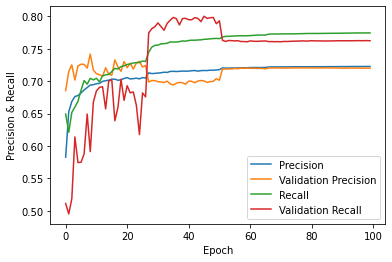

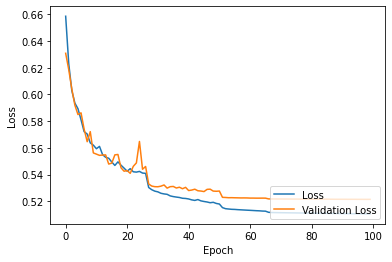

In [19]:
# Plot F1score
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Precision & Recall')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Predict on validation set
y_pred = model.predict(valid_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.reshape(-1)

# Print number of 1s and 0s
print("1 count", np.count_nonzero(y_pred == 1))
print("0 count", np.count_nonzero(y_pred == 0))

# Print F1 Score
print("F1 Score : ", f1_score(y_val.numpy().astype(int), y_pred))

37/37 [==============================] - 1s 14ms/step
1 count 39391
0 count 35217
f1 score :  0.7406217765417108


In [27]:
def format_customers(df_customers, df_locations):
    df_customers = df_customers.drop(["language", "dob", "created_at", "updated_at"], axis=1)

    df_customers["gender"] = df_customers["gender"].str.strip()
    df_customers["gender"] = df_customers["gender"].str.upper()
    df_customers["gender"] = df_customers["gender"].map({'MALE': 0, 'FEMALE': 1})
    df_customers["gender"] = df_customers.gender.fillna(2).astype(int)

    df_customers = df_customers.drop(["verified", "status"], axis=1)
    df_customers = df_customers.rename(columns={"akeed_customer_id": "customer_id"})

    df_customers = pd.merge(df_customers, df_locations[["customer_id", "location_number", "latitude", "longitude"]], on="customer_id", how="outer")
    df_customers = df_customers.fillna(0)

    df_customers["gender"] = df_customers["gender"].astype(np.uint8)
    df_customers["location_number"] = df_customers["location_number"].astype(np.uint8)
    df_customers["latitude"] = df_customers["latitude"].astype(np.float16)
    df_customers["longitude"] = df_customers["longitude"].astype(np.float16)

    return df_customers

def format_items(df_orders):
    df_orders = df_orders[["akeed_order_id", "customer_id", "vendor_id", "deliverydistance"]]

    df_orders = df_orders.drop(["akeed_order_id"], axis=1)
    return df_orders

def format_vendors(df_vendors):
    to_remove = [
            "vendor_category_en",
            "authentication_id",
            "OpeningTime",
            "OpeningTime2",
            "open_close_flags",
            "vendor_tag_name",
            "created_at",
            "updated_at",
            "commission",
            "saturday_to_time1",
            "saturday_from_time2",
            "saturday_from_time1",
            "saturday_to_time2",
            "thursday_to_time1",
            "thursday_from_time1",
            "thursday_from_time2",
            "thursday_to_time2",
            "tuesday_to_time1",
            "tuesday_from_time2",
            "tuesday_from_time1",
            "tuesday_to_time2",
            "monday_to_time1",
            "monday_from_time1",
            "monday_from_time2",
            "monday_to_time2",
            "sunday_to_time1",
            "sunday_from_time1",
            "sunday_from_time2",
            "sunday_to_time2",
            "friday_to_time1",
            "friday_from_time1",
            "friday_from_time2",
            "friday_to_time2",
            "wednesday_to_time1",
            "wednesday_from_time1",
            "wednesday_from_time2",
            "wednesday_to_time2",
            "one_click_vendor",
            "country_id",
            "city_id",
            "display_orders",
            "device_type",
            "is_akeed_delivering",
            "language",
            "rank",
            "is_open"
    ]

    df_vendors = df_vendors.drop(to_remove, axis=1)
    # remove all unverified accounts
    # df_vendors = df_vendors[df_vendors["verified"] == 1]
    df_vendors = df_vendors.drop("verified", axis=1)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].fillna("{\"primary_tags\":\"0\"}").astype(str).map(lambda x: x.split("\"")[3]).astype(int)

    # one hot encoding for vendor_tag
    df_vendors_tags = df_vendors.vendor_tag.str.split(",")
    df_vendors_tags = df_vendors_tags.apply(lambda d: d if isinstance(d, list) else [])

    mlb = MultiLabelBinarizer()
    one_hot_encoded_data = mlb.fit_transform(df_vendors_tags)
    one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data, columns=mlb.classes_, dtype=bool)

    # merge df_train_items and one_hot_encoded_data
    df_vendors = df_vendors.drop(["vendor_tag"], axis=1)
    df_vendors = df_vendors.reset_index(drop=True)
    one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)
    df_vendors = pd.concat([df_vendors, one_hot_encoded_data], axis=1)

    df_vendors["latitude"] = df_vendors["latitude"].astype(np.float16)
    df_vendors["longitude"] = df_vendors["longitude"].astype(np.float16)
    df_vendors["vendor_category_id"] = df_vendors["vendor_category_id"].astype(np.uint8)
    df_vendors["delivery_charge"] = df_vendors["delivery_charge"].astype(bool)
    df_vendors["serving_distance"] = df_vendors["serving_distance"].astype(np.uint8)
    df_vendors["prepration_time"] = df_vendors["prepration_time"].astype(np.uint8)
    df_vendors["discount_percentage"] = df_vendors["discount_percentage"].astype(np.uint8)
    df_vendors["status"] = df_vendors["status"].astype(bool)
    df_vendors["vendor_rating"] = df_vendors["vendor_rating"].astype(np.float16)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].astype(np.uint16)
    df_vendors["id"] = df_vendors["id"].astype(np.uint16)
    
    return df_vendors

def format_test_dataset(df_customers, df_orders, df_vendors, df_locations):
    df_customers = format_customers(df_customers, df_locations)
    df_orders = format_items(df_orders)
    df_vendors = format_vendors(df_vendors)

    print(df_customers.shape, df_orders.shape, df_vendors.shape)

    # get the cross merge product of users, items and rests
    
    C = pd.merge(df_customers, df_vendors, how="cross")
    sub = C[["customer_id", "location_number", "id"]]
    C = C.drop(["customer_id", "id"], axis=1)

    return C, sub

In [28]:
df_X_test, df_submission = format_test_dataset(df_test_customers, df_orders, df_vendors, df_test_locations)

(16736, 5) (135303, 3) (100, 78)


In [29]:
X_test = tf.keras.utils.normalize(tf.convert_to_tensor(df_X_test.to_numpy(), dtype=tf.float32), axis=1)

In [30]:
# Predict the test set
y_pred = model.predict(X_test)
# Convert the prediction to binary
y_pred = np.where(y_pred > 0.5, 1, 0)
# Reshape the prediction to a 1D array
y_pred = y_pred.reshape(-1)

52300/52300 [==============================] - 284s 5ms/step


In [ ]:
# Create the submission file
df_submission["CID X LOC_NUM X VENDOR"] = df_submission["customer_id"].astype(str) + " X " + df_submission["location_number"].astype(str) + " X " + df_submission["id"].astype(str)
df_submission["target"] = y_pred
df_submission = df_submission.drop(["customer_id", "location_number", "id"], axis=1)
df_submission.to_csv("submission.csv", index=False)